In [ ]:
import sys
print(sys.executable)


In [2]:
import wfdb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


CUDA available: True
GPU name: NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
FOLDER = r"C:\Users\Sujith Reddy\Desktop\zip2ext\files"  # <-- CHANGE IF NEEDED


In [5]:
records = []
for file in os.listdir(FOLDER):
    if file.endswith(".hea"):
        records.append(file.replace(".hea", ""))

print("Records found:", records)


Records found: ['00735', '03665', '04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455']


In [4]:
import wfdb
import os
import numpy as np
import torch

data_dir = r"C:/Users/Sujith Reddy/Desktop/zip2ext/files"  # <-- CHANGE IF NEEDED
record_names = [f.replace('.hea', '') for f in os.listdir(data_dir) if f.endswith('.hea')]

all_signals = []
all_annotations = [] # This was missing

for name in record_names:
    file_path = os.path.join(data_dir, name)
    try:
        header = wfdb.rdheader(file_path)
        if header.n_sig == 0:
            continue
            
        # Load signal
        record = wfdb.rdrecord(file_path)
        
        # Load annotations
        annotation = wfdb.rdann(file_path, 'atr') 
        
        all_signals.append(record.p_signal[:, 0])
        all_annotations.append(annotation) # Store it here
        
        print(f"Loaded {name}")
    except Exception as e:
        print(f"Error on {name}: {e}")

print(f"Ready: {len(all_signals)} signals and {len(all_annotations)} annotations.")

Loaded 04015
Loaded 04043
Loaded 04048
Loaded 04126
Loaded 04746
Loaded 04908
Loaded 04936
Loaded 05091
Loaded 05121
Loaded 05261
Loaded 06426
Loaded 06453
Loaded 06995
Loaded 07162
Loaded 07859
Loaded 07879
Loaded 07910
Loaded 08215
Loaded 08219
Loaded 08378
Loaded 08405
Loaded 08434
Loaded 08455
Ready: 23 signals and 23 annotations.


In [25]:
def create_windows_debug(signals, annotations, seq_length=1000):
    X, y = [], []
    found_rhythms = set() # To track what labels are actually in your files

    for sig, ann in zip(signals, annotations):
        sig_len = len(sig)
        label_mask = np.zeros(sig_len)
        current_state = 0 
        
        # Sort annotations by sample index
        sort_idx = np.argsort(ann.sample)
        samples = np.array(ann.sample)[sort_idx]
        notes = np.array(ann.aux_note)[sort_idx]
        
        for i in range(len(samples)):
            idx = samples[i]
            note = str(notes[i]).strip()
            found_rhythms.add(note) # Debugging: collect all unique notes
            
            # Broad match: If 'AF' appears anywhere in the label
            if "AF" in note.upper():
                current_state = 1
            elif "(" in note: # Any other rhythm change resets to Normal
                current_state = 0
            
            label_mask[idx:] = current_state

        num_windows = sig_len // seq_length
        for i in range(num_windows):
            start, end = i * seq_length, (i + 1) * seq_length
            X.append(sig[start:end].reshape(-1, 1))
            y.append(1 if np.mean(label_mask[start:end]) > 0.5 else 0)
            
    print(f"Unique rhythm labels found in your files: {found_rhythms}")
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

# RE-RUN the windowing
X_train, y_train = create_windows_debug(all_signals, all_annotations)

# RE-APPLY Normalization
X_train = (X_train - X_train.mean(dim=1, keepdim=True)) / (X_train.std(dim=1, keepdim=True) + 1e-7)

# VERIFY THE FIX
print(f"Total Windows: {len(y_train)} | AFib Windows (1s): {int(y_train.sum())}")

Unique rhythm labels found in your files: {'J', 'AFL', 'AF', 'N'}
Total Windows: 210835 | AFib Windows (1s): 183444


In [26]:
import torch
import torch.nn as nn

class AFibLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, layer_dim=2):
        super(AFibLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM Layer: batch_first=True makes input (Batch, Seq_Len, Features)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=0.2)
        
        # Fully connected layer to map LSTM output to a single probability
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state and cell state with zeros on the GPU
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Classification based on the final time step
        out = self.fc(out[:, -1, :]) 
        return self.sigmoid(out)

# Now define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

# 1. Setup Balanced Data Loader
counts = torch.bincount(y_train.long())
weights = 1.0 / counts.float()
sample_weights = weights[y_train.long()]

# This sampler will pick AFib and Normal windows equally
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=64, sampler=sampler)

# 2. Initialize Model on GPU
model = AFibLSTM().to(device) 
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Training Loop
epochs = 20
model.train()

print(f"Starting training on {device} with {int(y_train.sum())} AFib samples...")
for epoch in range(epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 4. Save the trained weights
torch.save(model.state_dict(), "backend/app/ml/afib_lstm.pth")
print("Model saved successfully!")

Starting training on cuda with 183444 AFib samples...
Epoch [1/20], Loss: 0.6933
Epoch [2/20], Loss: 0.6925
Epoch [3/20], Loss: 0.6935
Epoch [4/20], Loss: 0.6933
Epoch [5/20], Loss: 0.6882
Epoch [6/20], Loss: 0.6585
Epoch [7/20], Loss: 0.4340
Epoch [8/20], Loss: 0.3151
Epoch [9/20], Loss: 0.5316
Epoch [10/20], Loss: 0.5085
Epoch [11/20], Loss: 0.4070
Epoch [12/20], Loss: 0.3278
Epoch [13/20], Loss: 0.2895
Epoch [14/20], Loss: 0.2562
Epoch [15/20], Loss: 0.2259
Epoch [16/20], Loss: 0.2043
Epoch [17/20], Loss: 0.1895
Epoch [18/20], Loss: 0.1741
Epoch [19/20], Loss: 0.1610
Epoch [20/20], Loss: 0.1526


RuntimeError: Parent directory backend/app/ml does not exist.

In [30]:
# 1. Set the additional epochs
extra_epochs = 10 
model.train()

print(f"Continuing training on {device} for {extra_epochs} more epochs...")

# Use range(21, 31) so your logs show the correct epoch numbers
for epoch in range(21, 21 + extra_epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch}/30], Loss: {running_loss/len(train_loader):.4f}")

# 2. Save the final model weights
torch.save(model.state_dict(), "backend/app/ml/afib_lstm_final.pth")
print("Final model saved successfully after 30 epochs!")

Continuing training on cuda for 10 more epochs...
Epoch [21/30], Loss: 0.1453
Epoch [22/30], Loss: 0.1372
Epoch [23/30], Loss: 0.1338
Epoch [24/30], Loss: 0.1259
Epoch [25/30], Loss: 0.1285
Epoch [26/30], Loss: 0.1221
Epoch [27/30], Loss: 0.1134
Epoch [28/30], Loss: 0.1136
Epoch [29/30], Loss: 0.1066
Epoch [30/30], Loss: 0.1034


RuntimeError: Parent directory backend/app/ml does not exist.

In [31]:
# 1. Set the additional epochs
extra_epochs = 10 
model.train()

print(f"Continuing training on {device} for epochs 31 to 40...")

for epoch in range(31, 31 + extra_epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch}/40], Loss: {running_loss/len(train_loader):.4f}")

# 2. Save the updated model weights
torch.save(model.state_dict(), "backend/app/ml/afib_lstm_40epochs.pth")
print("Model saved successfully after 40 epochs!")

Continuing training on cuda for epochs 31 to 40...
Epoch [31/40], Loss: 0.1016
Epoch [32/40], Loss: 0.0969
Epoch [33/40], Loss: 0.0961
Epoch [34/40], Loss: 0.3498
Epoch [35/40], Loss: 0.6001
Epoch [36/40], Loss: 0.4923
Epoch [37/40], Loss: 0.4689
Epoch [38/40], Loss: 0.3887
Epoch [39/40], Loss: 0.3437
Epoch [40/40], Loss: 0.3040


RuntimeError: Parent directory backend/app/ml does not exist.

In [33]:
# 1. Lower the learning rate to stabilize and fine-tune
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0001 

extra_epochs = 10 
model.train()

print(f"Continuing training on {device} for epochs 41 to 50 (LR=0.0001)...")

for epoch in range(41, 51):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch}/50], Loss: {running_loss/len(train_loader):.4f}")

# 2. Save the final optimized weights
torch.save(model.state_dict(), "backend/app/ml/afib_lstm_50epochs.pth")
print("Model saved successfully after 50 epochs of training!")

Continuing training on cuda for epochs 41 to 50 (LR=0.0001)...
Epoch [41/50], Loss: 0.2679
Epoch [42/50], Loss: 0.2626
Epoch [43/50], Loss: 0.2572
Epoch [44/50], Loss: 0.2521
Epoch [45/50], Loss: 0.2488
Epoch [46/50], Loss: 0.2448
Epoch [47/50], Loss: 0.2391
Epoch [48/50], Loss: 0.2351
Epoch [49/50], Loss: 0.2344
Epoch [50/50], Loss: 0.2285


RuntimeError: Parent directory backend/app/ml does not exist.

In [35]:
print(f"Total Labels: {len(y_train)} | AFib Windows (1s): {int(y_train.sum())} | Normal Windows (0s): {int(len(y_train) - y_train.sum())}")

Total Labels: 210835 | AFib Windows (1s): 183444 | Normal Windows (0s): 27391


Evaluating model...

--- Final Results ---
Accuracy: 0.9053
Recall:   0.8899  <-- This should no longer be 0.0000!
F1-Score: 0.9038


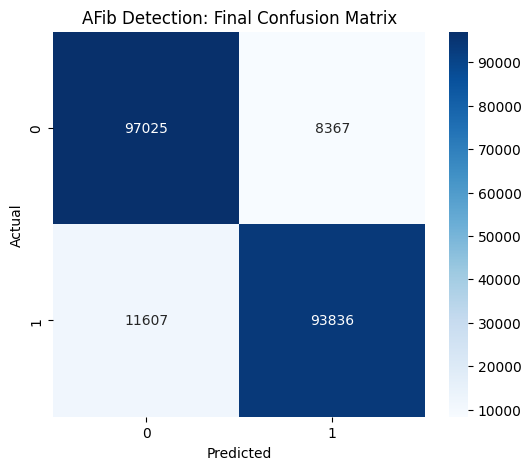

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

print("Evaluating model...")
with torch.no_grad():
    for batch_X, batch_y in train_loader: # You can also use a separate test_loader
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        preds = (outputs > 0.5).float().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch_y.numpy())

# Calculate Metrics
acc = accuracy_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\n--- Final Results ---")
print(f"Accuracy: {acc:.4f}")
print(f"Recall:   {rec:.4f}  <-- This should no longer be 0.0000!")
print(f"F1-Score: {f1:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("AFib Detection: Final Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Sample Index: 500
Model Confidence: 0.9953
Model Prediction: AFib Detected
Actual Label:     AFib


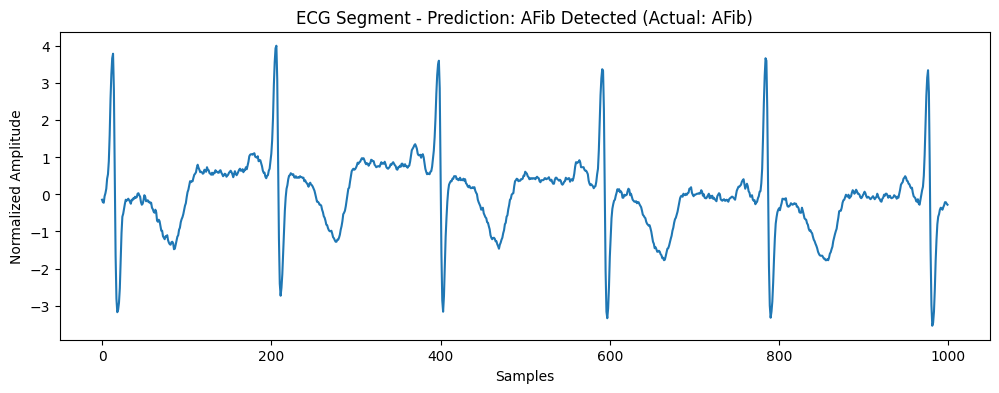

In [36]:
import matplotlib.pyplot as plt

# 1. Pick a specific sample from your training data (e.g., index 500)
sample_idx = 500 
sample_signal = X_train[sample_idx].unsqueeze(0).to(device) # Add batch dimension and move to GPU
actual_label = y_train[sample_idx].item()

# 2. Get Prediction
model.eval()
with torch.no_grad():
    raw_output = model(sample_signal)
    prediction = (raw_output > 0.5).float().item()

# 3. Display Results
status = "AFib Detected" if prediction == 1 else "Normal Rhythm"
truth = "AFib" if actual_label == 1 else "Normal"

print(f"Sample Index: {sample_idx}")
print(f"Model Confidence: {raw_output.item():.4f}")
print(f"Model Prediction: {status}")
print(f"Actual Label:     {truth}")

# 4. Visualize the signal the model just analyzed
plt.figure(figsize=(12, 4))
plt.plot(X_train[sample_idx].cpu().numpy())
plt.title(f"ECG Segment - Prediction: {status} (Actual: {truth})")
plt.xlabel("Samples")
plt.ylabel("Normalized Amplitude")
plt.show()

In [38]:
import torch
import os

# Go to ASSIGNMENT folder (same logic as XGBoost)
BASE_DIR = os.path.dirname(os.getcwd())

MODEL_DIR = os.path.join(BASE_DIR, "backend", "app", "ml_assets")
os.makedirs(MODEL_DIR, exist_ok=True)

# ----- SAVE ONLY WEIGHTS (BEST PRACTICE) -----
torch_path = os.path.join(MODEL_DIR, "lstm_stroke_model.pt")
torch.save(model.state_dict(), torch_path)

print(f"LSTM model saved at: {torch_path}")


LSTM model saved at: c:\Users\Sujith Reddy\Desktop\assignment\backend\app\ml_assets\lstm_stroke_model.pt
